In [40]:
%load_ext autoreload
%autoreload 2

import json
import matplotlib.pyplot as plt
import seaborn as sns
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
with open("../results/alignment_tax_v1.03.json", "r") as f:
    random_results = json.load(f)
with open("../results/alignment_tax_v1.04.json", "r") as f:
    acts_results = json.load(f)
with open("../results/alignment_tax_v1.05.json", "r") as f:
    pos_acts_results = json.load(f)

same = random_results["only_code"].keys() == acts_results["only_code"].keys()
print(f"Are both results with the same ICs?: {same}")
random_results["meta"], acts_results['meta']

Are both results with the same ICs?: True


({'model_name': 'meta-llama/Llama-2-7b-chat-hf',
  'layer': 29,
  'batch_size': 1,
  'max_seq_length': 4096,
  'total_tokens_per_batch': 100000,
  'injection_coefficients': [0, 20, 40, 75, 100, 150, 200, 250, 300, 400, 500],
  'note': 'Random activations, more ics and bfloat16'},
 {'model_name': 'meta-llama/Llama-2-7b-chat-hf',
  'act_file_path': 'data/activations/acts_v1.0_Llama-2-7b-chat-hf_5000.pt',
  'layer': 29,
  'batch_size': 1,
  'max_seq_length': 4096,
  'total_tokens_per_batch': 100000,
  'injection_coefficients': [0, 20, 40, 75, 100, 150, 200, 250, 300, 400, 500],
  'note': 'Same config as 1.03, but no random acts and no bfloat'})

In [62]:
metrics = ("top1_acc", "top10_acc", "skip50_top1_acc", "skip50_top10_acc")
modes = ("only_text", "only_code")
injection_coefficients = list(acts_results["only_code"].keys())

def extract_scores(results):
    #TODO: really messy code, should work on changing the structuring of the results
    accs = {}

    for mode in modes:
        accs[mode] = {}
        for metric in metrics:
            accs[mode][metric] = [0]*len(injection_coefficients), [0]*len(injection_coefficients)
        
        for i, ic in enumerate(injection_coefficients):
            keys_batches = results[mode][ic].keys()
            for batch in keys_batches:
                for metric in metrics:
                    score = results[mode][ic][batch][metric]
                    #NOTE: currently skipping nan, probs not best way of doing things.
                    if math.isnan(score):
                        continue
                    accs[mode][metric][0][i] += score
                    accs[mode][metric][1][i] += 1

    avg_scores_dict = {mode: {} for mode in modes}
    relative_scores_dict = {mode: {} for mode in modes}

    for mode in modes:
        for metric in metrics:
        # for metric in ["skip50_top10_acc"]:
            sum_scores, counts = accs[mode][metric]
            avg_scores = [sum_score / count *100 for sum_score, count in zip(sum_scores, counts)]
            relative_scores = [avg_score / avg_scores[0] *100 for avg_score in avg_scores]
            avg_scores_dict[mode][metric] = avg_scores
            relative_scores_dict[mode][metric] = relative_scores
            # print(f"\n\nMetric: {metric}")
            # print(f"avg_score: {avg_scores}\n")
            # print(f"relative_scores: {relative_scores}")

    return avg_scores_dict, relative_scores_dict

In [63]:
rand_avg, rand_rel = extract_scores(random_results)
acts_avg, acts_rel = extract_scores(acts_results)
pos_acts_avg, pos_acts_rel = extract_scores(pos_acts_results)

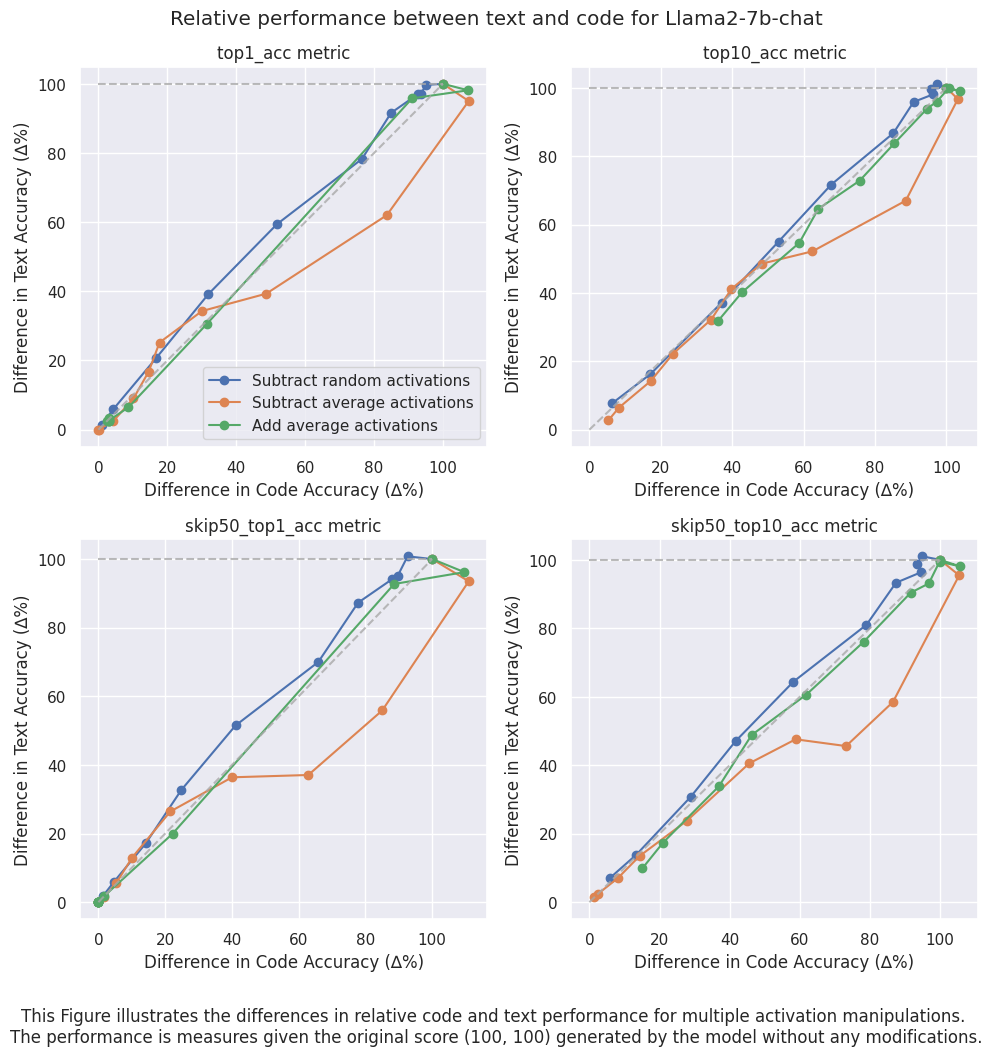

In [76]:
# create a seaborn style graph
sns.set_theme()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
scale = 100

for metric, ax in zip(metrics, axs.reshape(-1)):
    ax.plot(rand_rel["only_code"][metric], rand_rel['only_text'][metric], marker="o", label="Subtract random activations")
    ax.plot(acts_rel["only_code"][metric], acts_rel['only_text'][metric], marker="o", label="Subtract average activations")
    ax.plot(pos_acts_rel["only_code"][metric], pos_acts_rel['only_text'][metric], marker="o", label="Add average activations")
    ax.set_title(f"{metric} metric")
    ax.set_xlabel("Difference in Code Accuracy (∆%)")
    ax.set_ylabel("Difference in Text Accuracy (∆%)")

    ax.plot([0, scale], [scale, scale], color="darkgray", linestyle="--", alpha=0.8)
    ax.plot([0, scale], [0,     scale], color="darkgray", linestyle="--", alpha=0.8)

# title = results["meta"]["model_name"].split("/")[1]
axs[0, 0].legend()
title = "Relative performance between text and code for Llama2-7b-chat"
txt = """This Figure illustrates the differences in relative code and text performance for multiple activation manipulations. 
The performance is measures given the original score (100, 100) generated by the model without any modifications."""
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.suptitle(title)
fig.tight_layout()
plt.show()

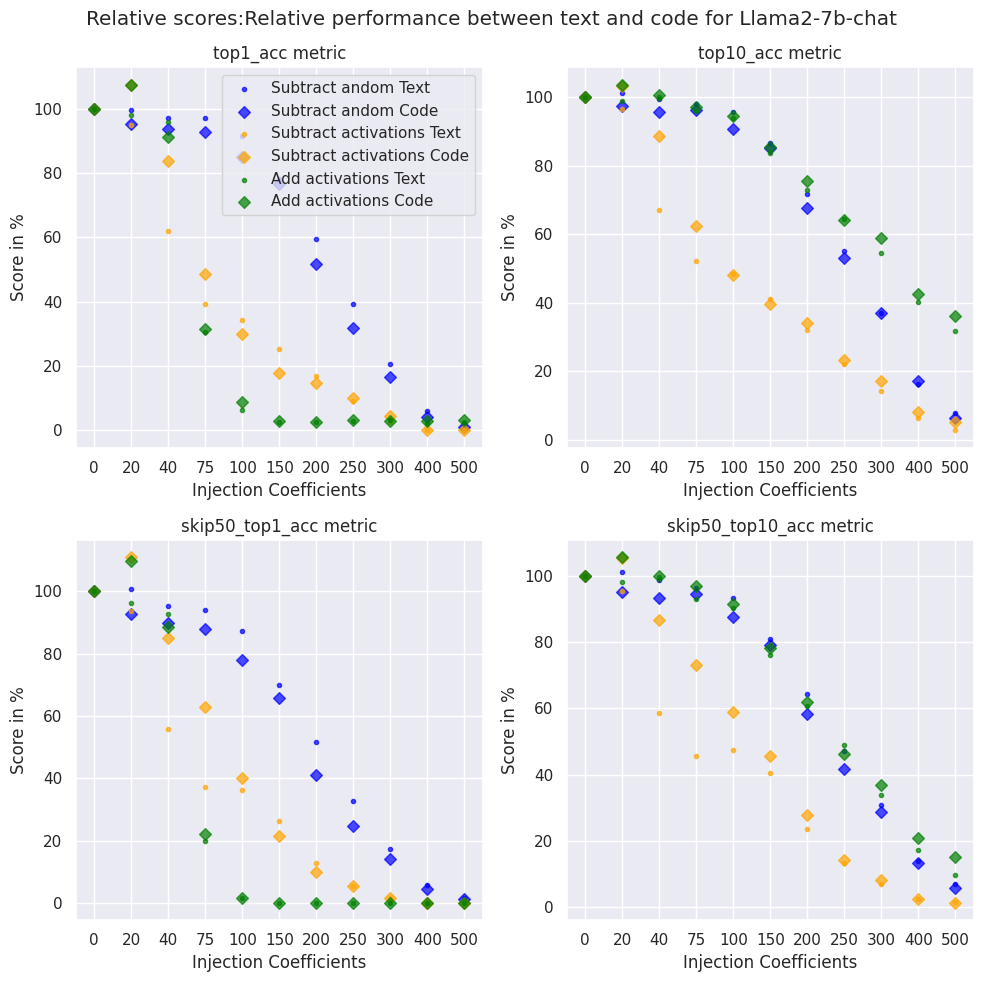

In [79]:
# create a seaborn style graph
sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(10,10))
scale = 100
ic_ints = [ic.split("_")[2] for ic in injection_coefficients]


for metric, ax in zip(metrics, axs.reshape(-1)):
    ax.scatter(ic_ints, rand_rel['only_text'][metric], marker=".", alpha=0.7, c="blue", label="Subtract andom Text")
    ax.scatter(ic_ints, rand_rel['only_code'][metric], marker="D", alpha=0.7, c="blue", label="Subtract andom Code")
    ax.scatter(ic_ints, acts_rel['only_text'][metric], marker=".", alpha=0.7, c="orange", label="Subtract activations Text")
    ax.scatter(ic_ints, acts_rel['only_code'][metric], marker="D", alpha=0.7, c="orange", label="Subtract activations Code")
    ax.scatter(ic_ints, pos_acts_rel['only_text'][metric], marker=".", alpha=0.7, c="green", label="Add activations Text")
    ax.scatter(ic_ints, pos_acts_rel['only_code'][metric], marker="D", alpha=0.7, c="green", label="Add activations Code")

    ax.set_title(f"{metric} metric")
    ax.set_xlabel("Injection Coefficients")
    ax.set_ylabel("Score in %")

axs[0, 0].legend()
plt.suptitle("Relative scores:" + title)
fig.tight_layout()
plt.show() 

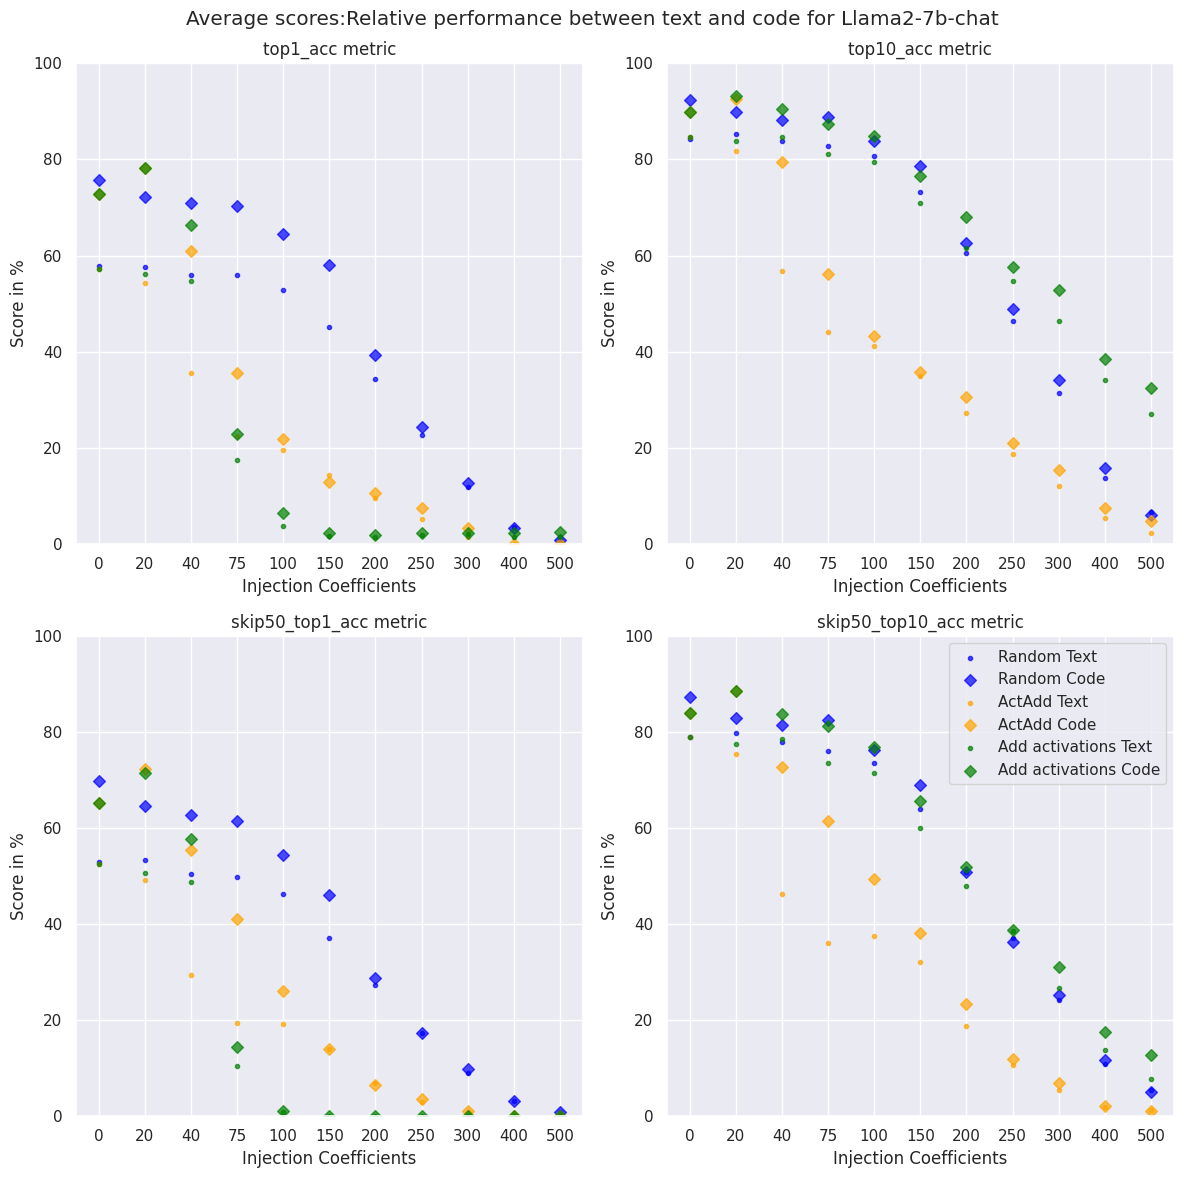

In [80]:
# create a seaborn style graph
sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(12, 12))#, sharex=True, sharey=True)
scale = 100
ic_ints = [ic.split("_")[2] for ic in injection_coefficients]

for metric, ax in zip(metrics, axs.reshape(-1)):
    ax.set_ylim([0, 100])

    ax.scatter(ic_ints, rand_avg['only_text'][metric], marker=".", alpha=0.7, c="blue", label="Random Text")
    ax.scatter(ic_ints, rand_avg['only_code'][metric], marker="D", alpha=0.7, c="blue", label="Random Code")
    ax.scatter(ic_ints, acts_avg['only_text'][metric], marker=".", alpha=0.7, c="orange", label="ActAdd Text")
    ax.scatter(ic_ints, acts_avg['only_code'][metric], marker="D", alpha=0.7, c="orange", label="ActAdd Code")
    ax.scatter(ic_ints, pos_acts_avg['only_text'][metric], marker=".", alpha=0.7, c="green", label="Add activations Text")
    ax.scatter(ic_ints, pos_acts_avg['only_code'][metric], marker="D", alpha=0.7, c="green", label="Add activations Code")
    
    ax.set_title(f"{metric} metric")

    ax.set_xlabel("Injection Coefficients")
    ax.set_ylabel("Score in %")
    
plt.legend()
plt.suptitle("Average scores:" + title)
fig.tight_layout()
plt.show()

In [35]:
with open("../results/alignment_tax_v1.02.json", "r") as f:
    f16_results = json.load(f)

with open("../results/alignment_tax_v1.03.json", "r") as f:
    bf16_results = json.load(f)

f16_results['meta'], bf16_results['meta']

({'model_name': 'meta-llama/Llama-2-7b-chat-hf',
  'layer': 29,
  'batch_size': 1,
  'max_seq_length': 4096,
  'total_tokens_per_batch': 100000,
  'injection_coefficients': [0, 5, 20, 30, 40, 50, 75, 100, 150, 200, 300],
  'note': 'Random activations'},
 {'model_name': 'meta-llama/Llama-2-7b-chat-hf',
  'layer': 29,
  'batch_size': 1,
  'max_seq_length': 4096,
  'total_tokens_per_batch': 100000,
  'injection_coefficients': [0, 20, 40, 75, 100, 150, 200, 250, 300, 400, 500],
  'note': 'Random activations, more ics and bfloat16'})

In [37]:
#TODO: really messy code, should work on changing the structuring of the results
f16_speeds, bf16_speeds = [], []
modes = ("only_text", "only_code")
f16_ics = list(f16_results["only_code"].keys())
bf16_ics = list(bf16_results["only_code"].keys())

for mode in modes:
    accs[mode] = {}
    
    for ic in f16_ics:
        keys_batches = f16_results[mode][ic].keys()
        for batch in keys_batches:
            f16_speeds.append(f16_results[mode][ic][batch]["total_time_in_sec"])

    for ic in bf16_ics:
        keys_batches = bf16_results[mode][ic].keys()
        for batch in keys_batches:
            bf16_speeds.append(bf16_results[mode][ic][batch]["total_time_in_sec"])

In [41]:
def avg_speed(x):
    return sum(x) / len(x)

print(f"f16 avg speed: {avg_speed(f16_speeds)}")
print(f"bf16 avg speed: {avg_speed(bf16_speeds)}")

f16 avg speed: 0.17110445615716316
bf16 avg speed: 0.18862386200287454


In [46]:
4*32*4096

524288

In [47]:
26_000_000_000 / 524288


49591.064453125

In [45]:
40*128

5120